## 1.Import python packages

In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

import pyodbc
import urllib
import sqlalchemy
'''destination databases'''
params_datahub = urllib.parse.quote_plus("DRIVER={ODBC Driver 17 for SQL Server};"
                                 "SERVER=localhost\SQLEXPRESS;"
                                 "DATABASE=datahub;"
                                 "UID=sa;"
                                 "PWD=user1")
engine_datahub = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params_datahub))

In [2]:
directoryPath=''
df_dealer=pd.read_csv(directoryPath+'dealer.csv')

In [3]:
# correct name of sales persons
fix_type = {'Jim Vegler':'Jim Vogler','Jim Voglr':'Jim Vogler','Mansor Naser':'Mansur Naser','MansurNaser':'Mansur Naser','Nora Palerno':'Nora Palermo','Norah Palarmo':'Nora Palermo','Norah Palermo':'Nora Palermo','Rachael Arellano':'Rachel Arellano','Rachel Arelleno':'Rachel Arellano','Samine Gupta':'Samin Gupta','Simin Gupta':'Samin Gupta'}
df_dealer['salesperson']= df_dealer['salesperson'].replace(fix_type)
df_dealer

,dealer_key,DealerName,salesperson
0,0,Motorcars Honda,Samin Gupta
1,1,A J Dohmann Chevrolet Cadillac,Rachel Arellano
2,2,Evert's Motor Sales,Samin Gupta
3,3,Walker Auto Group Inc,Jim Vogler
4,4,Simple Enterprises,Nora Palermo
...,...,...,...
100,100,Gorges Volvo,Jim Vogler
101,101,Hiller Ford Inc,Jim Vogler
102,102,Morrow Brothers Ford Inc,Samin Gupta
103,103,Frank Shirey Cadillac,Jim Vogler


In [4]:
df_dealer.to_csv(directoryPath+'dealer2.csv',index=False)

In [5]:
from datetime import datetime
import datetime as dt
from datetime import date
def monthly(x):
    return dt.datetime(x.year,x.month, 1)

In [6]:
df_submission_history=pd.read_csv(directoryPath+'submission_history.csv')
df_submission_history['submission_date'] = df_submission_history['submission_date'].apply(pd.to_datetime)

In [7]:
df_submission_history['submission_mth'] = df_submission_history['submission_date'].apply(monthly)
df_submission_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6883 entries, 0 to 6882
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   application_id   6883 non-null   int64         
 1   submission_id    6883 non-null   int64         
 2   submission_date  6883 non-null   datetime64[ns]
 3   revenue          6883 non-null   int64         
 4   submission_mth   6883 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(3)
memory usage: 269.0 KB


In [8]:
df_submission_history.to_csv(directoryPath+'submission_history2.csv',index = False)

#### Update the file in the SQL from csv

In [9]:
import glob
directoryPath=r"C:\Users\nim\Documents\ZZZ-Data Analysis Training\Business_Data_Analysis\Bizdata Analytics workshop 1\Project_car_lease/"

for file_name in glob.glob(directoryPath+'*.csv'):
        print(Path(file_name).stem)
        x = pd.read_csv(file_name)
        x.to_sql(Path(file_name).stem, engine_datahub,if_exists='replace',index=False)

application
dealer
dealer2
submission_history
submission_history2


#### refresh data models 

In [10]:
# directoryPath=r"C:\Users\nim\Documents\ZZZ-Data Analysis Training\Business_Data_Analysis\Bizdata Analytics workshop 1\Project_car_lease/"
# for file_name in glob.glob(directoryPath+'*.sql'):    
#         with open(file_name, 'r') as sql_file:
#             engine_datahub.execute(sql_file.read())
#         print(Path(file_name).stem)
#         print(file_name)

In [11]:
df_submission_history.head(10)

,application_id,submission_id,submission_date,revenue,submission_mth
0,200000,1842,2022-04-20,1690,2022-04-01
1,200001,2458,2022-05-04,2490,2022-05-01
2,200001,4983,2022-05-04,2520,2022-05-01
3,200002,833,2022-07-09,1980,2022-07-01
4,200002,2299,2022-07-09,2010,2022-07-01
5,200002,4525,2022-07-08,2070,2022-07-01
6,200003,3749,2022-07-27,2030,2022-07-01
7,200004,615,2022-04-06,2180,2022-04-01
8,200004,4947,2022-04-08,2060,2022-04-01
9,200005,735,2022-05-14,1330,2022-05-01


In [12]:
directoryPath=r"C:\Users\nim\Documents\ZZZ-Data Analysis Training\Business_Data_Analysis\Bizdata Analytics workshop 1\Project_car_lease/"
df_application=pd.read_csv(directoryPath+'application.csv')
df_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3423 entries, 0 to 3422
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   application_id  3423 non-null   int64 
 1   dealer_key      3423 non-null   int64 
 2   status          3423 non-null   object
dtypes: int64(2), object(1)
memory usage: 80.4+ KB


In [194]:
df_application_dealer_sales = pd.merge(df_application,df_dealer,on = 'dealer_key',how = 'left')

In [195]:
df_submission_application = pd.merge(df_submission_history,df_application_dealer_sales,on = 'application_id',how = 'left')
# df_submission_application

In [141]:
df_submission_times = pd.DataFrame(df_submission_application.groupby(['salesperson','application_id'])['submission_id'].count()).reset_index()
df_submission_times2 = pd.DataFrame(df_submission_times.groupby(['salesperson','submission_id'])['application_id'].nunique().unstack().fillna(0)).reset_index()
df_submission_times3 = df_submission_times2.rename({1:'one_sub',2:'double_sub',3:'triple_sub'},axis=1)
df_submission_times3['total_sub']=df_submission_times3['one_sub']+df_submission_times3['double_sub']+df_submission_times3['triple_sub']
df_submission_times3['sub_rate']= df_submission_times3['total_sub']/len(df_submission_application['submission_id'])
df_submission_times3

submission_id,salesperson,one_sub,double_sub,triple_sub,total_sub,sub_rate
0,Jim Vogler,243,270,260,773,0.112306
1,Mansur Naser,229,234,228,691,0.100392
2,Nora Palermo,179,196,203,578,0.083975
3,Rachel Arellano,214,206,202,622,0.090368
4,Samin Gupta,253,244,262,759,0.110272


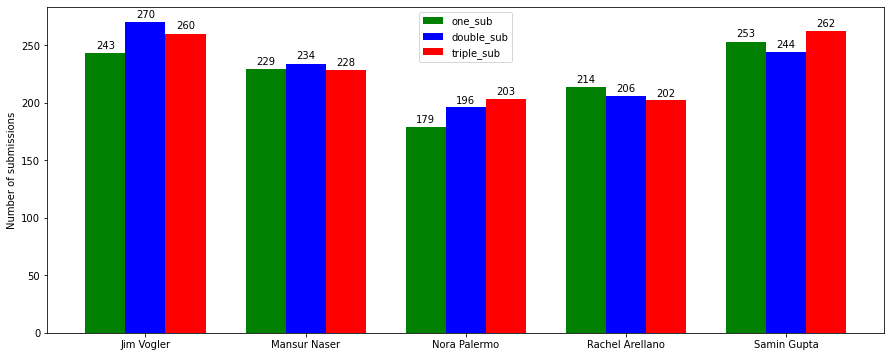

In [193]:
import numpy as np
import matplotlib.pyplot as plt
  
N = 5
ind = np.arange(N) 
width = 0.25
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
  
one_sub_list = df_submission_times3['one_sub'].to_list()
rects1 = ax.bar(ind, one_sub_list, width, color = 'g')

two_sub_list = df_submission_times3['double_sub'].to_list()
rects2 = ax.bar(ind+width,two_sub_list,width,color = 'b')

three_sub_list = df_submission_times3['triple_sub'].to_list()
rects3 = ax.bar(ind+width*2,three_sub_list,width,color = 'r')

ax.set_ylabel('Number of submissions')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('Jim Vogler', 'Mansur Naser', 'Nora Palermo', 'Rachel Arellano', 'Samin Gupta') )
ax.legend( (rects1[0],rects2[0], rects3[0]), ('one_sub','double_sub', 'triple_sub') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*h, '%d'%int(h),
                ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()

# plt.bar(x_axis-0.1,one_sub_list,0.4,label = df_submission_times3.columns[1])
# plt.bar(x_axis+0.1,two_sub_list,0.4,label = df_submission_times3.columns[2])
# plt.bar(x_axis+0.1,two_sub_list,0.4,label = df_submission_times3.columns[3])

In [15]:
#nunique() is count unique function
df_submission_application_mth = df_submission_application.groupby(['DealerName','salesperson','submission_mth',])['application_id'].nunique().unstack()
df_submission_application_mth

,submission_mth,2022-04-01,2022-05-01,2022-06-01,2022-07-01
DealerName,salesperson,,,,
A J Dohmann Chevrolet Cadillac,Rachel Arellano,8.0,5.0,3.0,10.0
American Service Center Associates,Rachel Arellano,11.0,5.0,8.0,4.0
Art Kuzma Motors Inc,Mansur Naser,16.0,19.0,18.0,20.0
Audubon Chrysler Ctr,Samin Gupta,9.0,12.0,10.0,14.0
Auto One Express Inc,Mansur Naser,16.0,21.0,21.0,16.0
...,...,...,...,...,...
Used Car Store Inc,Mansur Naser,10.0,9.0,12.0,13.0
Walker Auto Group Inc,Jim Vogler,20.0,13.0,20.0,11.0
Weakley County Motors,Samin Gupta,11.0,6.0,10.0,7.0


In [17]:
df_submission_application_mth[df_submission_application_mth.columns[1]].values[0] 

5.0

In [18]:
len(df_submission_application_mth.index)

90

In [19]:
status = []

for i in range(len(df_submission_application_mth.index)):
    if df_submission_application_mth[df_submission_application_mth.columns[1]].values[i] >=3 and df_submission_application_mth[df_submission_application_mth.columns[2]].values[i]>=3 and df_submission_application_mth[df_submission_application_mth.columns[3]].values[i]>=3:
        status.append('consistently active')
    elif df_submission_application_mth[df_submission_application_mth.columns[1]].values[i] ==0 and df_submission_application_mth[df_submission_application_mth.columns[2]].values[i]==0 and df_submission_application_mth[df_submission_application_mth.columns[3]].values[i]==0 and df_submission_application_mth[df_submission_application_mth.columns[4]].values[i]==0:
        status.append('dormant')
    else:
        status.append('not active')
    i = i + 1
print(status)

['consistently active', 'consistently active', 'consistently active', 'consistently active', 'consistently active', 'consistently active', 'consistently active', 'consistently active', 'not active', 'not active', 'consistently active', 'consistently active', 'consistently active', 'consistently active', 'consistently active', 'not active', 'consistently active', 'consistently active', 'consistently active', 'consistently active', 'not active', 'not active', 'not active', 'consistently active', 'consistently active', 'consistently active', 'consistently active', 'consistently active', 'consistently active', 'not active', 'consistently active', 'consistently active', 'consistently active', 'consistently active', 'consistently active', 'not active', 'consistently active', 'consistently active', 'consistently active', 'consistently active', 'consistently active', 'not active', 'not active', 'consistently active', 'consistently active', 'not active', 'consistently active', 'consistently act

In [20]:
df_submission_application_mth['sales_status']=status
df_dealer_sales_status = pd.DataFrame(df_submission_application_mth['sales_status']).reset_index()
df_dealer_sales_status

,DealerName,salesperson,sales_status
0,A J Dohmann Chevrolet Cadillac,Rachel Arellano,consistently active
1,American Service Center Associates,Rachel Arellano,consistently active
2,Art Kuzma Motors Inc,Mansur Naser,consistently active
3,Audubon Chrysler Ctr,Samin Gupta,consistently active
4,Auto One Express Inc,Mansur Naser,consistently active
...,...,...,...
85,Used Car Store Inc,Mansur Naser,consistently active
86,Walker Auto Group Inc,Jim Vogler,consistently active
87,Weakley County Motors,Samin Gupta,consistently active
88,Why Pay More Motors,Nora Palermo,consistently active


In [196]:
df_sales_active_dealer_count = pd.DataFrame(df_dealer_sales_status.query("sales_status =='consistently active'").groupby('salesperson')['sales_status'].count())
# df_sales_active_dealer_count

In [197]:
df_sales_total_dealer_count = pd.DataFrame(df_dealer.groupby('salesperson')['DealerName'].count())
# df_sales_total_dealer_count

In [24]:
df_active_dealer_stat = pd.merge(df_sales_active_dealer_count,df_sales_total_dealer_count,on='salesperson',how = 'inner')
df_active_dealer_stat1= df_active_dealer_stat.rename({'sales_status':'active_dealer_count','DealerName':'total_dealer_count'},axis=1)
df_active_dealer_stat1['active_dealer_percent'] = round(df_active_dealer_stat1['active_dealer_count']/df_active_dealer_stat1['total_dealer_count'],2)
df_active_dealer_stat1['inactive_dealer_percent']= round(1-df_active_dealer_stat1['active_dealer_percent'],2)
df_active_dealer_stat1

,active_dealer_count,total_dealer_count,active_dealer_percent,inactive_dealer_percent
salesperson,,,,
Jim Vogler,14,21,0.67,0.33
Mansur Naser,14,20,0.70,0.30
Nora Palermo,12,17,0.71,0.29
Rachel Arellano,12,22,0.55,0.45
Samin Gupta,15,25,0.60,0.40


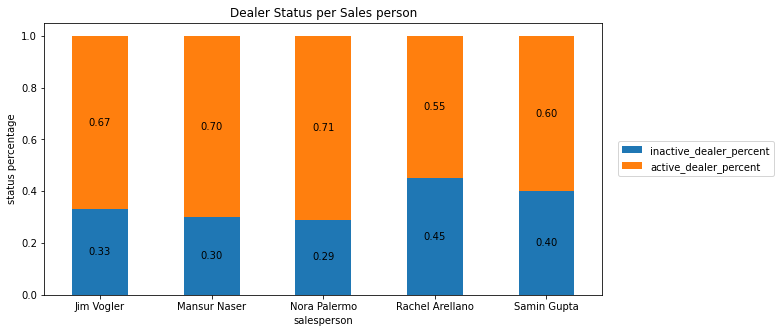

In [25]:
import matplotlib.pyplot as plt
df_active_dealer_stat2 = df_active_dealer_stat1.drop(['active_dealer_count','total_dealer_count'],axis=1)
df_active_dealer_stat3 = df_active_dealer_stat2.iloc[:,[1,0]] #reverse sequence of columns to plot active on top

ax = df_active_dealer_stat3.plot(kind='bar', stacked=True, figsize=(10, 5), rot=0, xlabel='salesperson', ylabel='status percentage',title = 'Dealer Status per Sales person')
for c in ax.containers:
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, fmt='%0.2f', label_type='center')

plt.legend(['inactive_dealer_percent','active_dealer_percent'],loc='center left', bbox_to_anchor=(1.02, 0.5))

In [26]:
visit = []
for n in range(len(df_submission_application_mth.index)):
    if df_submission_application_mth[df_submission_application_mth.columns[1]].values[n] >=5 and df_submission_application_mth[df_submission_application_mth.columns[2]].values[n]>=5 and df_submission_application_mth[df_submission_application_mth.columns[3]].values[n]<3:
        visit.append('in-person visit')
    else:
        visit.append('no visit')
    n = n + 1
print(visit)

['no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'in-person visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visit', 'no visi

In [27]:
df_submission_application_mth['visit_status'] = visit

In [28]:
df_submission_application_mth.query("visit_status == 'in-person visit'")

,submission_mth,2022-04-01 00:00:00,2022-05-01 00:00:00,2022-06-01 00:00:00,2022-07-01 00:00:00,sales_status,visit_status
DealerName,salesperson,,,,,,
Dynamic Ink Design,Nora Palermo,3.0,6.0,5.0,2.0,not active,in-person visit


In [29]:
df_valid_submission_date = df_submission_history.groupby('application_id').agg({'submission_date':'max'}).reset_index()
df_measure_submission_history0=pd.merge(df_submission_history,df_valid_submission_date,on=['application_id','submission_date'],how='inner')

In [30]:
# df_measure_submission_history0.head(10)

In [31]:
df_valid_submission_id = df_measure_submission_history0.groupby('application_id').agg({'submission_id':'max'}).reset_index()
df_measure_submission_history = pd.merge(df_measure_submission_history0,df_valid_submission_id,on=['application_id','submission_id'],how='inner')

In [32]:
# df_measure_submission_history.head(10)

In [33]:
df_dealer_rev = pd.merge(df_measure_submission_history,df_application,on = 'application_id',how = 'inner')
df_salesperson_rev = pd.merge(df_dealer_rev,df_dealer,on = 'dealer_key',how = 'left')
# df_salesperson_rev

In [34]:
df_salesperson_rev_valid = df_salesperson_rev.query("status == 'Approved'")
# df_salesperson_rev_valid
# sales_person_list = df_salesperson_rev_valid['salesperson'].unique()
# df_salesperson_rev_valid.query("salesperson == @sales_person_list[2]").sort_values('submission_date').head(20)

In [35]:
df_salesperson_avg_rev =pd.DataFrame(df_salesperson_rev_valid.groupby('salesperson')['revenue'].mean())
df_salesperson_avg_rev1= df_salesperson_avg_rev['revenue'].sort_values(ascending = False)
df_salesperson_avg_rev1

salesperson
Samin Gupta        1999.038760
Mansur Naser       1995.462185
Nora Palermo       1963.211382
Rachel Arellano    1963.121597
Jim Vogler         1946.717557
Name: revenue, dtype: float64

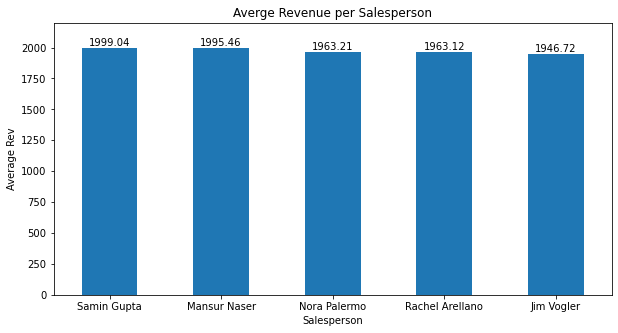

In [36]:
import matplotlib.pyplot as plt
# fig, ax = plt.subplots(figsize=(10, 5))
# sns.barplot(x=df_salesperson_avg_rev.index,y = 'revenue', data = df_salesperson_avg_rev)
ax = df_salesperson_avg_rev1.plot(kind='bar', figsize=(10,5), rot=0, title='Averge Revenue per Salesperson',
             xlabel='Salesperson', ylabel='Average Rev', legend=False)

# annotate
ax.bar_label(ax.containers[0], label_type='edge')

# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)

Average monthly sales performance is pretty much same accross the board. Samin Gupta leads a bit with Jim Vogler at the bottom

In [37]:
df_salesperson_mth_rev = pd.DataFrame(df_salesperson_rev_valid.groupby(['salesperson','submission_mth'])['revenue'].mean()).reset_index()
df_salesperson_mth_rev['submission_mth'] = df_salesperson_mth_rev['submission_mth'].astype(str)
# df_salesperson_mth_rev

In [38]:
salesperson_list = df_salesperson_mth_rev['salesperson'].unique()

In [39]:
label = salesperson_list[0]
label

'Jim Vogler'

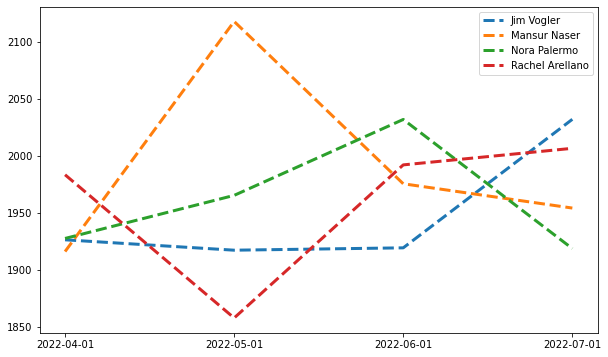

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

x=df_salesperson_mth_rev['submission_mth'][0:4].to_list()
y1=df_salesperson_mth_rev.query("salesperson==@salesperson_list[0]")['revenue'].to_list()
y2=df_salesperson_mth_rev.query("salesperson==@salesperson_list[1]")['revenue'].to_list()
y3=df_salesperson_mth_rev.query("salesperson==@salesperson_list[2]")['revenue'].to_list()
y4=df_salesperson_mth_rev.query("salesperson==@salesperson_list[3]")['revenue'].to_list()

plt.plot(x, y1, label = salesperson_list[0], linestyle="--",linewidth=3)
plt.plot(x, y2, label = salesperson_list[1], linestyle="--",linewidth=3)
plt.plot(x, y3, label = salesperson_list[2], linestyle="--",linewidth=3)
plt.plot(x, y4, label = salesperson_list[3], linestyle="--",linewidth=3)
plt.legend()
plt.show()

Jim Vogler and Rachel Allellano are improving their sales performance while Mansur Naser and Nora's performance are declining

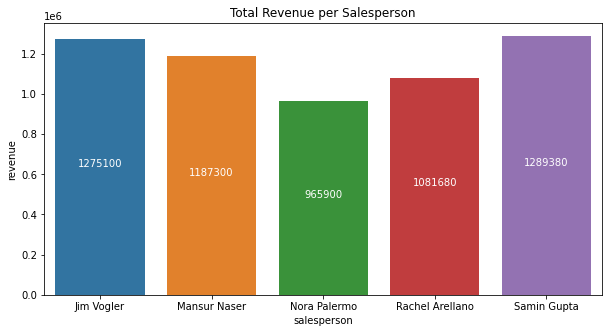

In [41]:
revenue_sum = df_salesperson_rev_valid.groupby('salesperson')['revenue'].sum()
df_saleperson_profitability = pd.DataFrame(df_salesperson_rev_valid.groupby('salesperson')['revenue'].sum())

import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

bar = sns.barplot(data = df_saleperson_profitability,x=df_saleperson_profitability.index,y = 'revenue')
bar.set(title='Total Revenue per Salesperson')
for i in range(len(revenue_sum)):
    bar.text(i,revenue_sum[i]/2,str(round(revenue_sum[i],2)),
             fontdict = dict(color='white',fontsize=10),
             horizontalalignment = 'center')

In [42]:
total_revenue = df_salesperson_rev_valid['revenue'].sum()
revenue_salesperson_list = df_salesperson_rev_valid.groupby('salesperson')['revenue'].sum().values

rev_percentage = []
for n in range(len(df_salesperson_rev_valid.groupby('salesperson')['revenue'].sum().index)):
    rev_percentage.append(revenue_salesperson_list[n]/total_revenue)

df_saleperson_profitability['rev_percentage'] = rev_percentage
df_saleperson_profitability

,revenue,rev_percentage
salesperson,,
Jim Vogler,1275100,0.219869
Mansur Naser,1187300,0.204729
Nora Palermo,965900,0.166553
Rachel Arellano,1081680,0.186517
Samin Gupta,1289380,0.222331


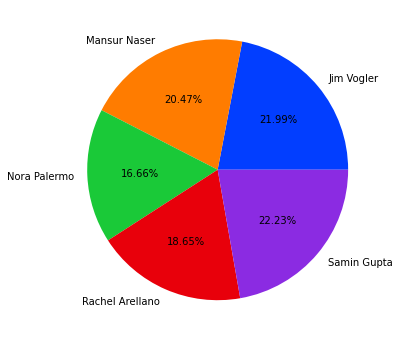

In [43]:
import matplotlib.pyplot as plt
import seaborn

plt.figure(figsize = (10,6))
palette_color = seaborn.color_palette('bright')

plt.pie(df_saleperson_profitability['rev_percentage'], labels=df_saleperson_profitability.index, colors=palette_color, autopct='%.2f%%')
# plt.legend()
plt.show()


In [44]:
total_revenue_80 = total_revenue * 0.8
total_revenue_80

4639488.0

In [45]:
df_topsales_dealer = pd.DataFrame(df_salesperson_rev_valid.groupby(['salesperson','DealerName'])['revenue'].sum()).reset_index().sort_values('revenue',ascending=False)
df_topsales_dealer_status = pd.merge(df_topsales_dealer,df_dealer_sales_status,on = 'DealerName',how = 'inner')
df_topsales_dealer_status.index = df_topsales_dealer_status.index + 1
df_topsales_dealer_status.head(50)['revenue'].sum()

4638710

In [46]:
50/(df_dealer['DealerName'].count())

0.47619047619047616

About 50% of the dealers contributed 80% of the total revenue. Not exactly follow the 80-20 principle

In [47]:
dealer_with_submission_history = df_dealer_sales_status['DealerName'].unique()
dealer_with_submission_history_count = len(df_dealer_sales_status['DealerName'].unique())
#90

In [48]:
submission_status_true_false = []
for m in range(len(df_dealer['DealerName'].unique())):
    if df_dealer['DealerName'][m] in dealer_with_submission_history:
        submission_status_true_false.append('submission_status_true')
    else:
        submission_status_true_false.append('submission_status_false')

In [49]:
df_dealer['submission_status_true_false'] = submission_status_true_false
df_submission_status_true_false = pd.DataFrame(df_dealer.groupby('submission_status_true_false').DealerName.count())

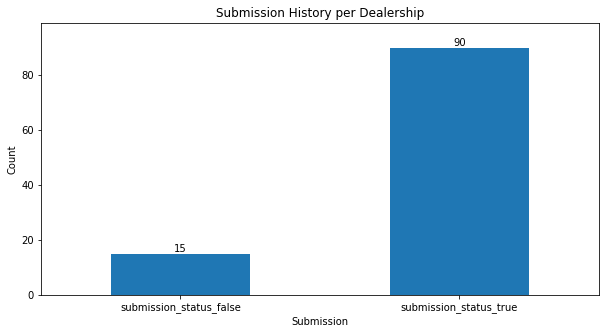

In [50]:
import matplotlib.pyplot as plt
ax = df_submission_status_true_false.plot(kind='bar', figsize=(10,5), rot=0, title='Submission History per Dealership',
             xlabel='Submission', ylabel='Count', legend=False)

# annotate
ax.bar_label(ax.containers[0], label_type='edge')

# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)

In [51]:
df_dealer.query("DealerName not in @dealer_with_submission_history")

,dealer_key,DealerName,salesperson,submission_status_true_false
12,12,Bagott Motors,Jim Vogler,submission_status_false
16,16,Reed's Point Chrysler,Samin Gupta,submission_status_false
26,26,Lee Truck Broker Inc,Samin Gupta,submission_status_false
27,27,Woodhouse Nissan,Rachel Arellano,submission_status_false
29,29,Parkway Mitsibushi,Mansur Naser,submission_status_false
35,35,Henry's Motor Sales,Nora Palermo,submission_status_false
36,36,Julian's Auto Showcase,Nora Palermo,submission_status_false
39,39,Chapparal Motors,Samin Gupta,submission_status_false
41,41,Rushville Chrysler Dodge Jeep,Nora Palermo,submission_status_false
44,44,Holiday Ford Lincoln Mercury,Mansur Naser,submission_status_false


status
Approved    5799360
Rejected     966590
Name: revenue, dtype: int64

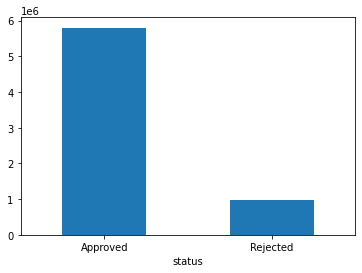

In [57]:
df_salesperson_rev.groupby('status')['revenue'].sum().plot(kind= 'bar',rot=0)
df_salesperson_rev.groupby('status')['revenue'].sum()

In [68]:
df_approved_rejected = df_salesperson_rev.groupby(['salesperson','DealerName','status'])['DealerName'].count().unstack()
df_approved_rejected

status                                     Approved  Rejected
salesperson DealerName                                       
Jim Vogler  Bud Weiser Chevrolet-Cadillac      22.0       3.0
            Concours Auto Sales Inc            55.0       8.0
            Cooper Buick Pontiac GMC Inc       33.0       8.0
            F F Fisher Sales & Leasing         17.0       9.0
            Frank Shirey Cadillac              45.0       7.0
...                                             ...       ...
Samin Gupta Payton Wells Chevrolet Inc          8.0       NaN
            Richard Chevrolet Geo Inc          10.0       1.0
            Twin Motors Ford Inc               29.0       3.0
            Weakley County Motors              28.0       6.0
            Wilson Motor Co                    25.0       5.0

[90 rows x 2 columns]

In [72]:
df_approved_rejected['percent_of_rejection']=round(df_approved_rejected['Rejected']/(df_approved_rejected['Approved']+df_approved_rejected['Rejected']),2)
df_approved_rejected.sort_values('percent_of_rejection',ascending = False).head(5)

status                                              Approved  Rejected  \
salesperson     DealerName                                               
Jim Vogler      F F Fisher Sales & Leasing              17.0       9.0   
Samin Gupta     Harvey's Chevrolet Oldsmobile            5.0       2.0   
Rachel Arellano American Service Center Associates      20.0       8.0   
                Crown Chrysler Jeep                     16.0       6.0   
Jim Vogler      Sweetwater Nissan                        6.0       2.0   

status                                              percen_of_rejection  \
salesperson     DealerName                                                
Jim Vogler      F F Fisher Sales & Leasing                     0.346154   
Samin Gupta     Harvey's Chevrolet Oldsmobile                  0.285714   
Rachel Arellano American Service Center Associates             0.285714   
                Crown Chrysler Jeep                            0.272727   
Jim Vogler      Sweetwater Nissan                              0.250000   

status                                              percent_of_rejection  
salesperson     DealerName                                                
Jim Vogler      F F Fisher Sales & Leasing                          0.35  
Samin Gupta     Harvey's Chevrolet Oldsmobile                       0.29  
Rachel Arellano American Service Center Associates                  0.29  
                Crown Chrysler Jeep                                 0.27  
Jim Vogler      Sweetwater Nissan                                   0.25

F F Fisher Sales & Leasing has the highest rejection rate - need a talk with Jim Vogler to investigate the reason

In [81]:
df_approved_rejected_salesperson = df_approved_rejected.reset_index()
df_approved_rejected_salesperson1 = pd.DataFrame(df_approved_rejected_salesperson.groupby('salesperson')['percent_of_rejection'].mean()).sort_values('percent_of_rejection',ascending=False)
df_approved_rejected_salesperson1 

,percent_of_rejection
salesperson,
Jim Vogler,0.165882
Samin Gupta,0.152500
Nora Palermo,0.146429
Mansur Naser,0.145000
Rachel Arellano,0.136875


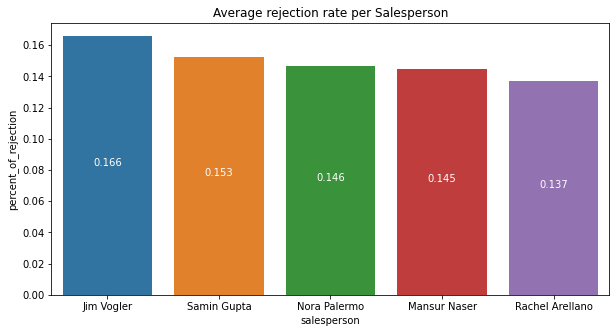

In [93]:
average_rejection_rate = df_approved_rejected_salesperson.groupby('salesperson')['percent_of_rejection'].mean().sort_values(ascending=False)
len(average_rejection_rate)
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

# sns.barplot(x=df_approved_rejected_salesperson1.index,y = 'percent_of_rejection', data = df_approved_rejected_salesperson1)
bar = sns.barplot(data = df_approved_rejected_salesperson1,x=df_approved_rejected_salesperson1.index,y = 'percent_of_rejection')
bar.set(title='Average rejection rate per Salesperson')
for i in range(len(average_rejection_rate)):
    bar.text(i,average_rejection_rate[i]/2,str(round(average_rejection_rate[i],3)),
             fontdict = dict(color='white',fontsize=10),
             horizontalalignment = 'center')

Jim Vogler's dealer base has the highest rejection rate. Might need a check with Jim Vogler on the reason